<a href="https://colab.research.google.com/github/sai-darshan-k/Writer_Identification_Kannada/blob/main/Kannada_hack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Writer Indentification from Kannada Hand Written Documents

In [ ]:
pip install pdf2image

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install PyMuPDF

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install pillow

Note: you may need to restart the kernel to use updated packages.


## Convert PDF to Images

In [ ]:
import os
import fitz  #PyMuPDF
from PIL import Image  #pillow for image manipulation

def pdf_to_images(pdf_path, output_dir, skip_first_pages=0):
    """Convert each page of the PDF to an image, with an option to skip initial pages."""
    pdf_document = fitz.open(pdf_path)

    for page_number in range(skip_first_pages, len(pdf_document)):
        page = pdf_document[page_number]
        pix = page.get_pixmap()  #render page to an image
        output_image_path = os.path.join(output_dir, f'page_{page_number + 1 - skip_first_pages}.png')
        pix.save(output_image_path)  #saving image

    pdf_document.close()  #close the PDF document

def rotate_image_left(image_path):
    with Image.open(image_path) as img:
        rotated_img = img.rotate(90, expand=True)  #rotateleft to extract information precisely
        rotated_img.save(image_path)  #saving rotated image

def process_pdf_for_writer(pdf_path, writer_name, output_base_dir, skip_first_pages=0):
    """Process the PDF for a specific writer and convert to images, with an option to skip pages."""
    writer_dir = os.path.join(output_base_dir, writer_name)
    os.makedirs(writer_dir, exist_ok=True)

    # Convert PDF to images, skipping the first two pages
    pdf_to_images(pdf_path, writer_dir, skip_first_pages)
    print(f'Processed PDF for {writer_name} and saved images to {writer_dir}')

    # Rotate images for the specific writer 'Guhan' (1File.pdf)
    if writer_name == 'Guhan':  # Change this to the writer associated with 1File.pdf
        for filename in os.listdir(writer_dir):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(writer_dir, filename)
                rotate_image_left(image_path)
                print(f'Rotated and saved image: {image_path}')

pdf_files_with_writers = [
    ('3file.pdf', 'Sai_Darshan'),
    ('2file.pdf', 'Suhas'),
    ('1File.pdf', 'Guhan'),
    ('4file.pdf', 'Rohith')
]

output_base_dir = 'dataset_dir'  #directory for output images

#process PDF's
for pdf_path, writer_name in pdf_files_with_writers:
    if writer_name == 'Rohith':
        process_pdf_for_writer(pdf_path, writer_name, output_base_dir, skip_first_pages=2)


Processed PDF for Rohith and saved images to dataset_dir\Rohith


## Importing Necessary Libararies Parameter Setting

In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

#Parameter setting
image_size = (128, 128)  #resize the images to this size
batch_size = 32
epochs = 6  #6 epochs are enough as per observation
target_images_per_writer = 53  #number of images to extract for each writer

## Data Loading and Balancing

c:\Users\saida\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


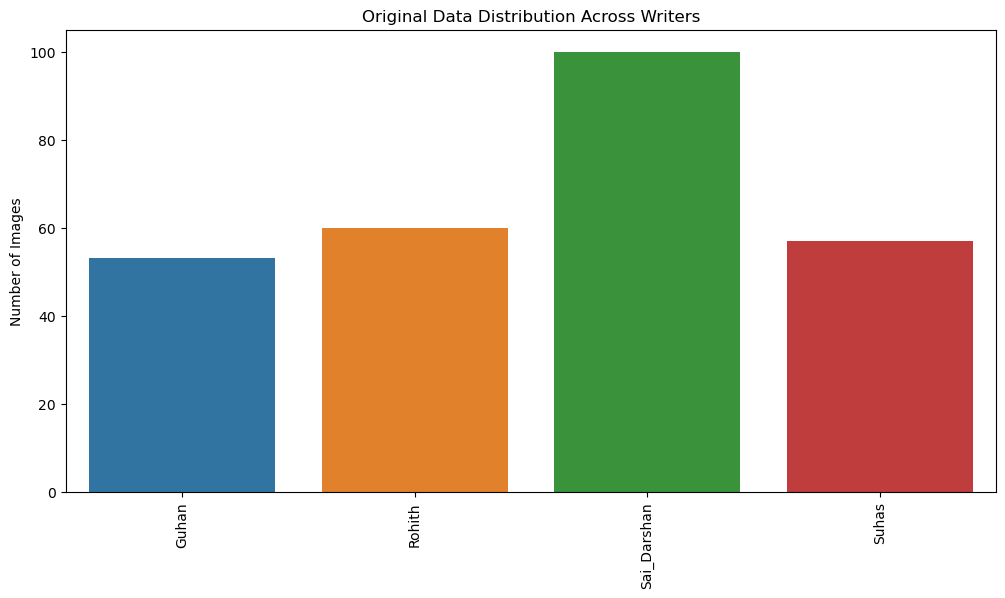

c:\Users\saida\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


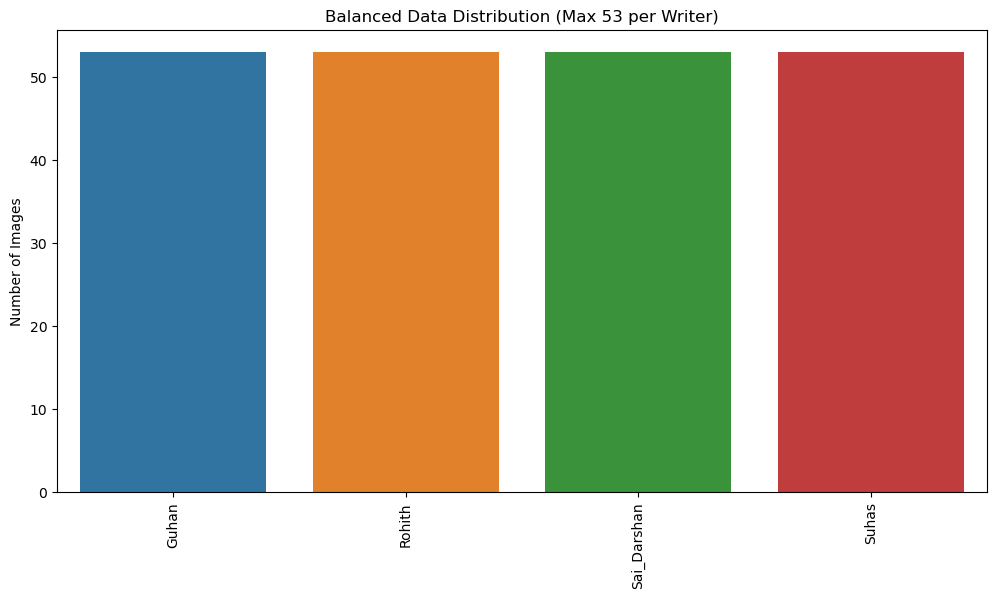

In [ ]:
#this function loads all images and then count them
def load_image_counts(dataset_dir):
    writer_names = os.listdir(dataset_dir)
    writer_counts = []

    for writer in writer_names:
        writer_dir = os.path.join(dataset_dir, writer)
        if os.path.isdir(writer_dir):
            img_files = [img for img in os.listdir(writer_dir) if img.endswith('.png')]
            writer_counts.append(len(img_files))  #count images for each writer

    return writer_names, writer_counts

#dataset load and get count
dataset_dir = 'dataset_dir'
writer_names, actual_counts = load_image_counts(dataset_dir)

#visualize original data
plt.figure(figsize=(12, 6))
sns.barplot(x=writer_names, y=actual_counts)
plt.xticks(rotation=90)
plt.title('Original Data Distribution Across Writers')
plt.ylabel('Number of Images')
plt.show()

#simulate balanced data
def balance_image_counts(writer_counts, target_count):
    balanced_counts = [min(count, target_count) for count in writer_counts]
    return balanced_counts

#get balanced counts
balanced_counts = balance_image_counts(actual_counts, target_images_per_writer)

#visualizing balanced data
plt.figure(figsize=(12, 6))
sns.barplot(x=writer_names, y=balanced_counts)
plt.xticks(rotation=90)
plt.title(f'Balanced Data Distribution (Max {target_images_per_writer} per Writer)')
plt.ylabel('Number of Images')
plt.show()


## Splitting Data

In [ ]:
#this function will load images and labels
def load_data(dataset_dir):
    images = []
    labels = []
    writer_names = os.listdir(dataset_dir)

    for writer_id, writer in enumerate(writer_names):
        writer_dir = os.path.join(dataset_dir, writer)
        if os.path.isdir(writer_dir):
            img_files = [img for img in os.listdir(writer_dir) if img.endswith('.png')]
            #limit to the target number of images per writer
            for img_name in img_files[:target_images_per_writer]:
                img_path = os.path.join(writer_dir, img_name)
                img = cv2.imread(img_path)
                img = cv2.resize(img, image_size)#Resize image
                images.append(img)
                labels.append(writer_id)#label by writer ID

    return np.array(images), np.array(labels), writer_names

dataset_dir = 'dataset_dir'
X, y, writer_names = load_data(dataset_dir)
#normalize pixel values
X = X.astype('float32') / 255.0

#spliting dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Augmentation and Compilation

In [ ]:
#Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest'
)

#load a pre-trained VGG16 model without the top layers
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))

#unfreeze the last few layers for fine-tuning
for layer in base_model.layers[-4:]:
    layer.trainable = True

#create a new model on top of the base model
model = keras.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),  # Add batch normalization
    layers.Dense(len(np.unique(y)), activation='softmax')  # Number of classes (writers)
])

#compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


## Model Training


In [ ]:
#early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#train the model with data augmentation and early stopping
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_val, y_val),
                    epochs=epochs,
                    callbacks=[early_stopping])

Epoch 1/6


C:\Users\saida\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.5828 - loss: 0.9447 - val_accuracy: 0.9070 - val_loss: 0.7807
Epoch 2/6
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9557 - loss: 0.1772 - val_accuracy: 0.8605 - val_loss: 0.5231
Epoch 3/6
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9983 - loss: 0.0363 - val_accuracy: 1.0000 - val_loss: 0.3260
Epoch 4/6
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9974 - loss: 0.0271 - val_accuracy: 1.0000 - val_loss: 0.1788
Epoch 5/6
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 1.0000 - loss: 0.0124 - val_accuracy: 1.0000 - val_loss: 0.0937
Epoch 6/6
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9983 - loss: 0.0222 - val_accuracy: 1.0000 - val_loss: 0.1029


## Training/Validation Loss and Accuracy Visualization

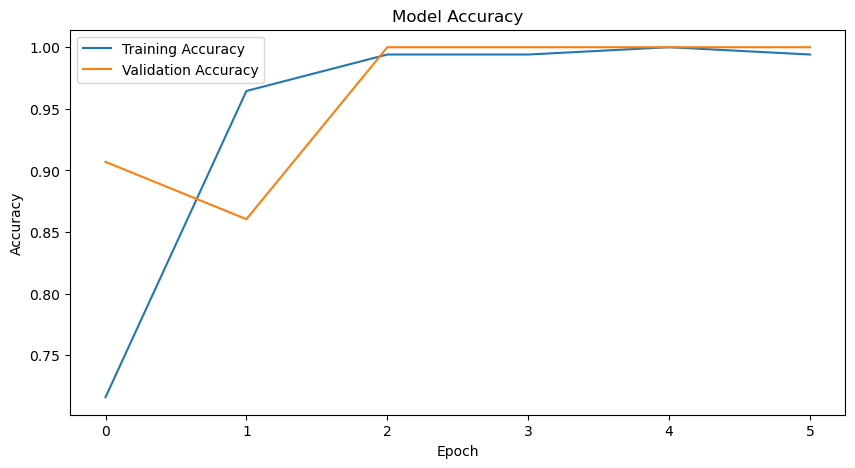

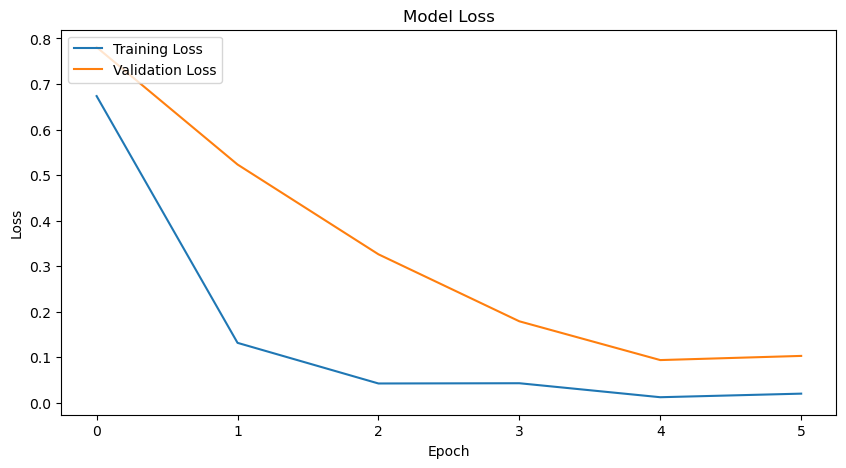

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

## Confusion Matrix

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step - accuracy: 1.0000 - loss: 0.0965
Validation Loss: 0.0937, Validation Accuracy: 1.0000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 396ms/step


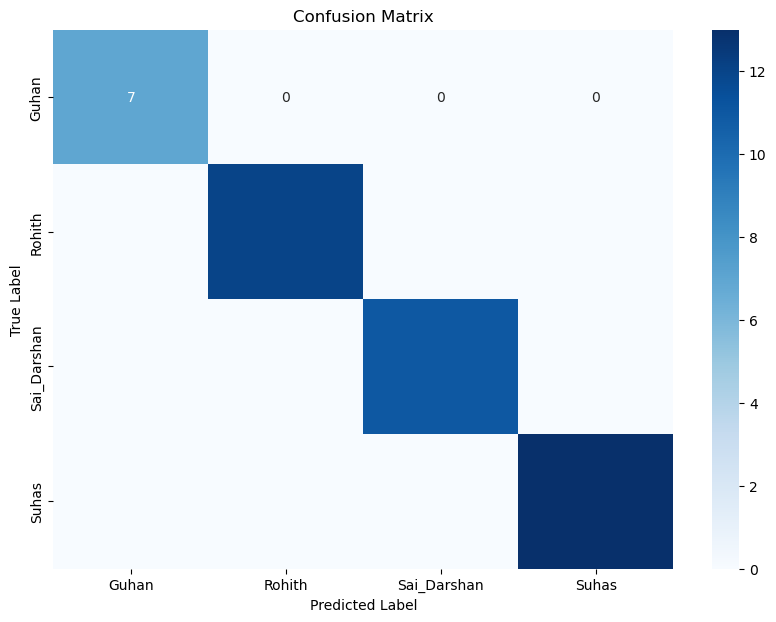

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}')

# Confusion Matrix
y_pred = np.argmax(model.predict(X_val), axis=1)
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=writer_names, yticklabels=writer_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

## Example test Usage

In [ ]:
test_image_path = 'dataset_dir/Rohith/page_7.png' #provide any name within the training set
predicted_writer = predict_writer(test_image_path)
print(f'The predicted writer is: {predicted_writer}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
The predicted writer is: Rohith


In [ ]:
# Save the model
model.save('writer_identification_model.h5')